my known lie doesn't make sense anymore? Well truth is when examples of truth are given (and maybe it's asked to tell the truth?) I would need to analyze this seperatly, but getting say N tokens. And trying differen't combinatiuons of system prompt, and n-shot examples


In [1]:
import torch
from IPython.display import display, HTML, Markdown
from torch.utils.data import random_split, DataLoader, TensorDataset
from loguru import logger
import sys
import pandas as pd
import seaborn as sns


logger.remove()
logger.add(sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2
from src.eval.collect import manual_collect2
from src.eval.ds import ds2df, qc_ds, qc_dsdf
from src.prompts.prompt_loading import load_prompts, format_prompt, load_preproc_dataset
from src.llms.load import load_model

from matplotlib import pyplot as plt
plt.style.use(['seaborn-v0_8'])


In [2]:
from pathlib import Path
BASE_FOLDER = Path("/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/")

# speed it up
decimate = 1
skip = 4
stride = 3
layers=['fc1', 'Wqkv', 'fc2', 'out_proj']

## Importance matrix

Wqkv torch.Size([32, 7680])
out_proj torch.Size([32, 2560])
fc1 torch.Size([32, 10240])
fc2 torch.Size([32, 2560])
torch.Size([32, 23040])


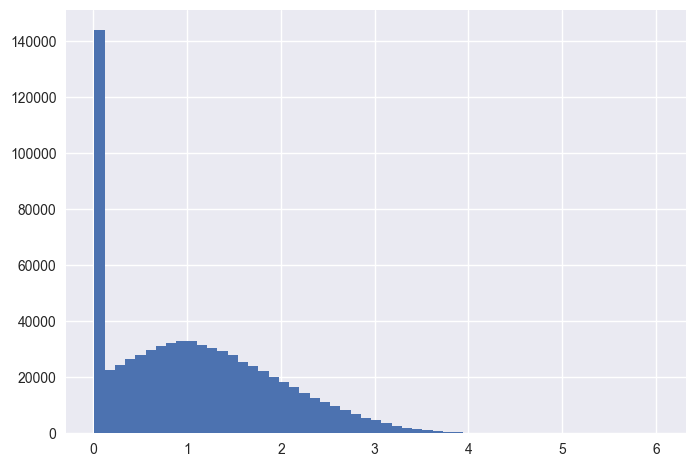

In [3]:
from src.probes.importance_matrix import get_importance_matrix

f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers)
print(importance_matrix.shape)
plt.hist(importance_matrix.flatten(), bins=55);


## Load DS

In [4]:
from datasets import Dataset

f1_val = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_valtest_*')))
f1_ood = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_OOD_*')))
f1_val, f1_ood

ds_val = Dataset.from_file(str(f1_val)).with_format("torch")
ds_ood = Dataset.from_file(str(f1_ood)).with_format("torch")

# ds_known1 = filter_ds_to_known(ds_out, verbose=True)

In [5]:
qc_ds(ds_val)
qc_ds(ds_ood)


with base model
with adapter
with base model
with adapter


({'balance': 0.49800399201596807,
  'N': 1002,
  'auroc': 0.7332721025955029,
  'lie_auroc': 0.3332161029631847,
  'known_lie_auroc': 0.31510177883733725,
  'choice_cov': 0.9814956},
 {'balance': 0.49800399201596807,
  'N': 1002,
  'auroc': 0.7332721025955029,
  'lie_auroc': 0.3332161029631847,
  'known_lie_auroc': 0.31510177883733725,
  'choice_cov': 0.9814956})

In [6]:
def agg_func(x):
    acc = (x.label_instructed == x["ans"]).mean()
    return pd.Series(dict(acc=acc, n=len(x)))

df = ds2df(ds_val)
df = df.rename(columns=lambda x: x.replace("_base", "")).copy()

for col in ["sys_instr_name", "ds_string"]:
    display(df.groupby(col).apply(agg_func))


,acc,n
sys_instr_name,,
false_none,0.258547,468.0
truth,0.743925,535.0


,acc,n
ds_string,,
amazon_polarity,0.485000,200.0
glue:qnli,0.555000,200.0
hans,0.507463,201.0
sst2,0.572139,201.0
super_glue:rte,0.467662,201.0


# Probe

In [7]:
from src.probes.lr import TorchRobustScaler, TorchLogisticRegression, TorchDummyClassifier
from src.helpers.ds import train_test_split_ds
from src.eval.pl_sk import analyze_dfres, SKEvaluator, PlainTruthEval

### LR

In [8]:
print('logistic regression')
evaluator = PlainTruthEval(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate, layers_names=layers)
model = TorchLogisticRegression(random_state=42, 
                                max_iter=10,
                                penalty='elasticnet',
                                # tol=1e-2,
                                solver='saga',
                                l1_ratio=0.5,
                                 class_weight='balanced',)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)

logistic regression


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


⭐ main_metric: 0.602 ⭐ roc_auc for 1002 OOD samples


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.620783,-0.104426,0.327586,58,True,True,0.672414,0.672414,0.617682,0.725209
sst2,0.737834,-0.145621,0.822581,62,True,True,0.790323,0.790323,0.62435,0.883455
amazon_polarity,0.738889,-0.228216,0.909091,66,True,True,0.909091,0.909091,0.833647,0.967105
super_glue:axg,0.589128,-0.22863,0.272455,334,False,False,0.757485,0.757485,0.772825,0.817758
imdb,0.6235,-0.281445,0.844311,334,False,False,0.844311,0.844311,0.793467,0.904945
super_glue:boolq,0.639507,-0.292498,0.805389,334,False,False,0.847305,0.847305,0.888254,0.932004
glue:qnli,0.370265,-0.320086,0.367647,68,True,True,0.647059,0.647059,0.582456,0.690351
super_glue:rte,0.502525,-0.361605,0.425532,47,True,True,0.765957,0.765957,0.788043,0.86413


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.620783,-0.104426,0.327586,58,True,True,0.672414,0.672414,0.617682,0.725209
sst2,0.737834,-0.145621,0.822581,62,True,True,0.790323,0.790323,0.62435,0.883455
amazon_polarity,0.738889,-0.228216,0.909091,66,True,True,0.909091,0.909091,0.833647,0.967105
super_glue:axg,0.589128,-0.22863,0.272455,334,False,False,0.757485,0.757485,0.772825,0.817758
imdb,0.6235,-0.281445,0.844311,334,False,False,0.844311,0.844311,0.793467,0.904945
super_glue:boolq,0.639507,-0.292498,0.805389,334,False,False,0.847305,0.847305,0.888254,0.932004
glue:qnli,0.370265,-0.320086,0.367647,68,True,True,0.647059,0.647059,0.582456,0.690351
super_glue:rte,0.502525,-0.361605,0.425532,47,True,True,0.765957,0.765957,0.788043,0.86413


In [9]:
print('DummyClassifier')
baseline_model = TorchDummyClassifier(random_state=42, strategy="most_frequent")
df_res2 = evaluator.eval(baseline_model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res2, insample_datasets, insample_datasets)

DummyClassifier
⭐ main_metric: 0.500 ⭐ roc_auc for 1002 OOD samples


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
glue:qnli,0.5,-0.190351,0.647059,68,True,True,0.647059,0.647059,0.582456,0.690351
hans,0.5,-0.225209,0.672414,58,True,True,0.672414,0.672414,0.617682,0.725209
super_glue:axg,0.5,-0.317758,0.757485,334,False,False,0.757485,0.757485,0.772825,0.817758
super_glue:rte,0.5,-0.36413,0.765957,47,True,True,0.765957,0.765957,0.788043,0.86413
sst2,0.5,-0.383455,0.790323,62,True,True,0.790323,0.790323,0.62435,0.883455
imdb,0.5,-0.404945,0.844311,334,False,False,0.844311,0.844311,0.793467,0.904945
super_glue:boolq,0.5,-0.432004,0.847305,334,False,False,0.847305,0.847305,0.888254,0.932004
amazon_polarity,0.5,-0.467105,0.909091,66,True,True,0.909091,0.909091,0.833647,0.967105


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
glue:qnli,0.5,-0.190351,0.647059,68,True,True,0.647059,0.647059,0.582456,0.690351
hans,0.5,-0.225209,0.672414,58,True,True,0.672414,0.672414,0.617682,0.725209
super_glue:axg,0.5,-0.317758,0.757485,334,False,False,0.757485,0.757485,0.772825,0.817758
super_glue:rte,0.5,-0.36413,0.765957,47,True,True,0.765957,0.765957,0.788043,0.86413
sst2,0.5,-0.383455,0.790323,62,True,True,0.790323,0.790323,0.62435,0.883455
imdb,0.5,-0.404945,0.844311,334,False,False,0.844311,0.844311,0.793467,0.904945
super_glue:boolq,0.5,-0.432004,0.847305,334,False,False,0.847305,0.847305,0.888254,0.932004
amazon_polarity,0.5,-0.467105,0.909091,66,True,True,0.909091,0.909091,0.833647,0.967105


# Other models

In [10]:
from src.probes.direct_bce_ranking import PLSK_BCE, PLSKWrapper
from src.eval.pl_sk import RankingTruthEval, DistTruthEval#, RankingObeyEval, PlainObeyEval
import numpy as np


max_epochs = 10
verbose = True
batch_size=16

In [11]:
# Unit test
for cls in [RankingTruthEval, DistTruthEval]:
    evaluator = cls(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix)
    proxy = evaluator.ds2proxy(ds_val)
    y1 = evaluator.proxy2label(proxy, ds_val)
    np.testing.assert_array_equal(y1==True, ds_val['label_true_base'], err_msg=f"undo_distance_truth_telling failed for {cls}")

In [12]:
# # Unit test
# for cls in [RankingObeyEval, PlainObeyEval]:
#     evaluator = cls(ds_trainval=ds_val, ds_test=ds_oos, importance_matrix=importance_matrix)
#     proxy = evaluator.ds2proxy(ds_val)
#     y1 = evaluator.proxy2label(proxy, ds_val)
#     np.testing.assert_array_equal(y1==True, ds_val['label_instructed_base'], err_msg=f"undo_distance_truth_telling failed for {cls}")

### Binary cross entropy

Binary cross entropy


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoar

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Con

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


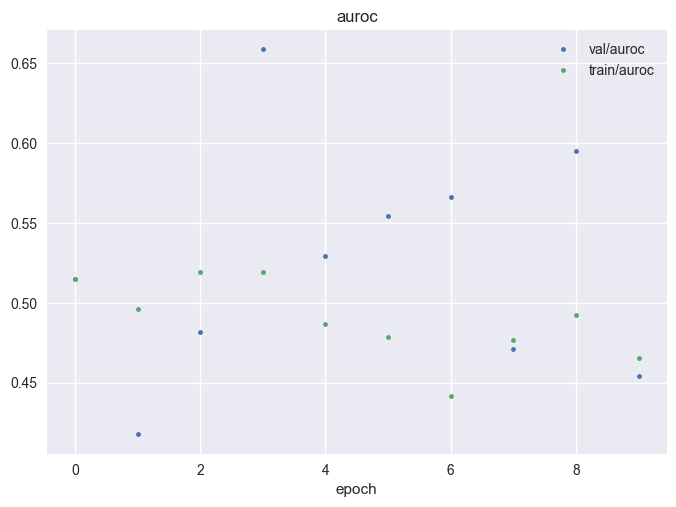

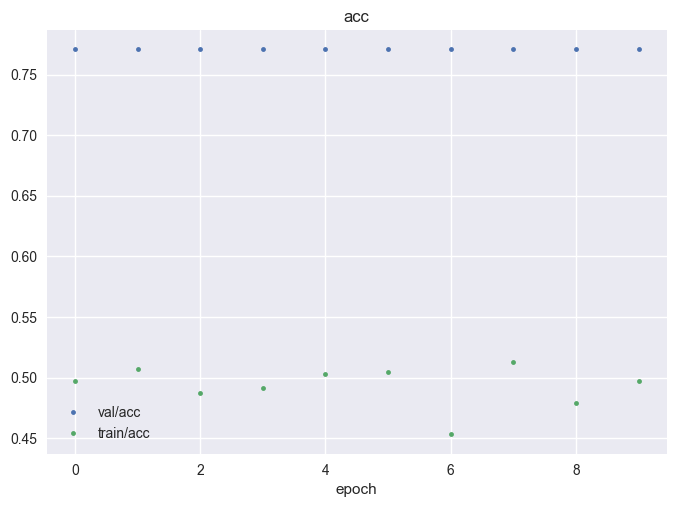

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

⭐ main_metric: 0.760 ⭐ roc_auc for 1002 OOD samples


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.792115,0.066906,0.724138,58,True,True,0.465517,0.724138,0.617682,0.725209
glue:qnli,0.683333,-0.007018,0.661765,68,True,True,0.558824,0.661765,0.582456,0.690351
sst2,0.842872,-0.040583,0.83871,62,True,True,0.5,0.83871,0.62435,0.883455
amazon_polarity,0.921992,-0.045113,0.893939,66,True,True,0.575758,0.893939,0.833647,0.967105
imdb,0.836817,-0.068127,0.826347,334,False,False,0.5,0.826347,0.793467,0.904945
super_glue:boolq,0.862428,-0.069576,0.856287,334,False,False,0.479042,0.856287,0.888254,0.932004
super_glue:axg,0.663814,-0.153944,0.691617,334,False,False,0.51497,0.691617,0.772825,0.817758
super_glue:rte,0.706522,-0.157609,0.723404,47,True,True,0.489362,0.723404,0.788043,0.86413


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.792115,0.066906,0.724138,58,True,True,0.465517,0.724138,0.617682,0.725209
glue:qnli,0.683333,-0.007018,0.661765,68,True,True,0.558824,0.661765,0.582456,0.690351
sst2,0.842872,-0.040583,0.83871,62,True,True,0.5,0.83871,0.62435,0.883455
amazon_polarity,0.921992,-0.045113,0.893939,66,True,True,0.575758,0.893939,0.833647,0.967105
imdb,0.836817,-0.068127,0.826347,334,False,False,0.5,0.826347,0.793467,0.904945
super_glue:boolq,0.862428,-0.069576,0.856287,334,False,False,0.479042,0.856287,0.888254,0.932004
super_glue:axg,0.663814,-0.153944,0.691617,334,False,False,0.51497,0.691617,0.772825,0.817758
super_glue:rte,0.706522,-0.157609,0.723404,47,True,True,0.489362,0.723404,0.788043,0.86413


In [13]:
print('Binary cross entropy')
evaluator = RankingTruthEval(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate, layers_names=layers)
epoch_steps = int(len(ds_val)*0.7//batch_size)

_X, _ = evaluator.ds2xy(ds_val)
c_in = _X.shape[1:]


pl_model = PLSK_BCE(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, dropout=0.25, hs=16, depth=3)
model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)

### MSE Ranking

MSE Ranking


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params
------------------------------------
0 | model | HSModel2d | 752 K 
------------------------------------
752 K     Trainable params
0         Non-trainable params
752 K     Total params
3.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


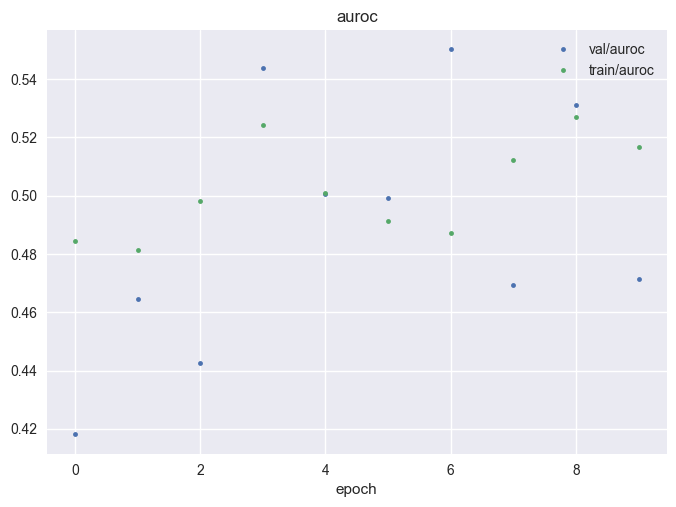

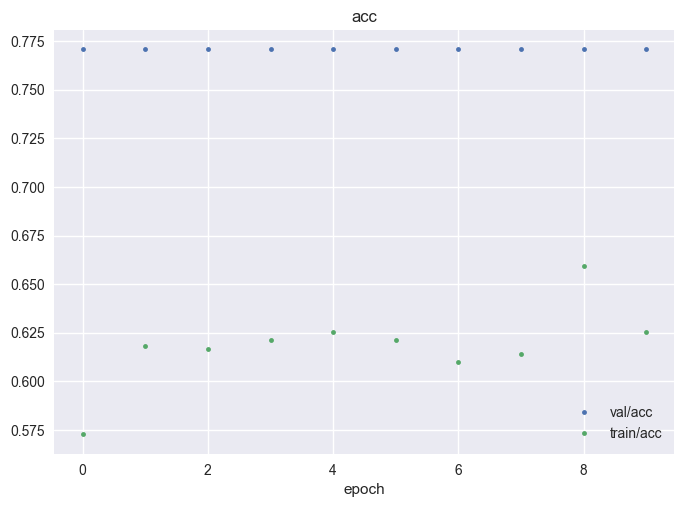

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

: 

In [14]:
from src.probes.mse_ranking import PLSKMSErank

print('MSE Ranking')
evaluator = RankingTruthEval(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate, layers_names=layers)
epoch_steps = int(len(ds_val)*0.7//batch_size)

_X, _ = evaluator.ds2xy(ds_val)
c_in = _X.shape[1:]


pl_model = PLSKMSErank(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, dropout=0.25, hs=16, depth=3)
model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)

### Bool ranking

In [ ]:
from src.probes.mse_ranking import PLSKBoolRank

print('MSE Ranking')
evaluator = RankingTruthEval(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate, layers_names=layers)
epoch_steps = int(len(ds_val)*0.7//batch_size)

_X, _ = evaluator.ds2xy(ds_val)
c_in = _X.shape[1:]


pl_model = PLSKBoolRank(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, dropout=0.25, hs=16, depth=3)
model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)

### ConformalLR

In [ ]:
from src.probes.conformal import MapieClassifier2
from sklearn.linear_model import LogisticRegression

print('ConformalLR')
evaluator = RankingTruthEval(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate, layers_names=layers)

clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced',)
model = MapieClassifier2(estimator=clf, 
                        # cv="prefit",
                        method="score",                        
                        )
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)

### CCS

In [ ]:
from src.probes.ccs import PLSKCCS

In [ ]:
max_epochs = 2
print('CCS')
evaluator = RankingTruthEval(ds_trainval=ds_val, ds_test=ds_ood, importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate, layers_names=layers)
epoch_steps = int(len(ds_val)*0.7//batch_size)

_X, _ = evaluator.ds2xy(ds_val)
c_in = _X.shape[1:]


pl_model = PLSKCCS(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, dropout=0.25, hs=16, depth=2)
model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)

# Compare importance matrix

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
from einops import rearrange
import safetensors.torch

def get_importance_matrix2(saved_adaptop_file, layers=['fc1', 'Wqkv']):
    state_dict = safetensors.torch.load_file(saved_adaptop_file)
    keys = sorted(state_dict.keys())
    if layers is None:
        layers = list(set([k.split('.')[-2] for k in state_dict.keys()]))

    activations = {}

    for k in keys:
        suffix = k.split('.')[-2]
        if suffix not in activations:
            activations[suffix] = []
        activations[suffix].append(state_dict[k])

    for k in activations.keys():
        activations[k] = rearrange(activations[k], 'l h b -> (b l) h').detach().cpu().float()
        print(k, activations[k].shape)


    importance_matrix = torch.concat([activations[i] for i in layers], dim=1)
    return importance_matrix

In [ ]:
print('no matrix')
evaluator = PlainTruthEval(ds_trainval=ds_val, ds_test=ds_ood, 
                        #    importance_matrix=importance_matrix
                           skip=skip, stride=stride, decimate=decimate
                           )
model = TorchLogisticRegression(random_state=42, 
                                penalty='elasticnet',
                                solver='saga',
                                l1_ratio=0.5,
                                 class_weight='balanced',)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
df_res_ana = analyze_dfres(df_res, insample_datasets, insample_datasets)

In [ ]:
print('matrix')
evaluator = PlainTruthEval(ds_trainval=ds_val, ds_test=ds_ood, 
                           importance_matrix=importance_matrix
                           , skip=skip, stride=stride, decimate=decimate
                           )
model = TorchLogisticRegression(random_state=42, 
                                penalty='elasticnet',
                                solver='saga',
                                l1_ratio=0.5,
                                 class_weight='balanced',)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)
roc_auc_score(df_res['y'], df_res['y_prob'])

In [ ]:
class PlainTruthEvalTop(PlainTruthEval):
    """only take the top X % of importance values."""

    def ds2xy(self, ds: Dataset):
        """function which will transform a dataset into x and y."""
        data = []
        for layer in self.layers_names:
            # Stack the base and adapter representations as a 4th dim
            X1 = [ds[f'end_residual_{layer}_base'], ds[f'end_residual_{layer}_adapt']]
            X1 = rearrange(X1, 'versions b l f  -> b l f versions')
            data.append(X1)
        
        # concat layers
        # x = rearrange(data, 'parts b l f v -> b l (parts f) v')
        x = torch.concat(data, dim=2)
        
        # restrict to non zero values
        mask = self.importance_matrix>1
        mask = rearrange(mask, 'l f -> (l f)')
        xf = rearrange(x, 'b l f v -> b (l f) v')[:, mask, :]
        print(f'keeping top {(mask*1.0).mean():2.2%} of values {x.shape} -> {xf.shape}')
        x = rearrange(xf, 'b lf v -> b lf 1 v') 
        y = self.ds2proxy(ds)
        return x, y


In [ ]:
print('top 10%')

importance_matrix = get_importance_matrix2(f, layers=layers)
importance_matrix = (importance_matrix-1).abs()
importance_matrix = importance_matrix / importance_matrix.std()
importance_matrix = importance_matrix + 1
importance_matrix = importance_matrix * ((importance_matrix>4))

# plt.hist(importance_matrix.flatten(), bins=55)
# plt.show();

evaluator = PlainTruthEvalTop(ds_trainval=ds_val, ds_test=ds_ood, 
                           importance_matrix=importance_matrix, skip=skip, stride=stride, decimate=decimate
                           )
model = TorchLogisticRegression(random_state=42, 
                                penalty='elasticnet',
                                solver='saga',
                                # max_iter=100,
                                l1_ratio=0.5,
                                 class_weight='balanced',)
df_res = evaluator.eval(model)
insample_datasets = list(set(ds_val['ds_string_base']))
analyze_dfres(df_res, insample_datasets, insample_datasets)